http://ned.ipac.caltech.edu/level5/March19/Baron/Baron2.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # statistical data visualization

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [2]:
# Using this to be able to plot spectra. For some reason Jupyter won't let me plot spectra without this
%matplotlib inline

## Create our own labels:
    - Random empty spot as noise
    
## Use entire spectrum and not encoded.

* Extracted entire noise spectrum. 

* Combine the high confidence and noise array. Here are the labels for it. 

### Ultimately, we want the ML algorithm to be able to pick out high-z sources from noise!

In [3]:
# loading in the decoded sources I got from inputting random encoded sources into t-sne.
# These will be our testing sample
random_highz_sources = np.load("highz_sources.npy")

In [4]:
# loading in my high confidence high z sources.
high_confidence_highz_spectra = np.load("high_confidence_highz_1000.npy", allow_pickle = True)

In [5]:
# loading in the noise sample.
noise_sample = np.load("noise_sample_1000.npy", allow_pickle = True)

## Random-Forest classification

https://levelup.gitconnected.com/random-forest-regression-209c0f354c84#:~:text=Random%20Forest%20Regression%20is%20a%20supervised%20learning%20algorithm%20that%20uses,prediction%20than%20a%20single%20model.

https://www.datacamp.com/tutorial/random-forests-classifier-python

## According to internet, issues with overfitting! Possibly need more data.

https://stackoverflow.com/questions/62445343/randomforestregressor-in-sklearn-giving-negative-scores

In [10]:
twodspectra = np.concatenate((high_confidence_highz_spectra, noise_sample))

In [11]:
highz_classification = np.ones(1000)
noise_classification = np.zeros(1000)

merge_classification = np.append(highz_classification, noise_classification)

### Make my own labels:
https://towardsdatascience.com/labeling-data-with-pandas-9e573ce59c42

In [12]:
X = twodspectra
y = merge_classification

In [13]:
# Splitting arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# i.e. 70 % training dataset and 30 % test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [14]:

# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier

### Note on number of estimators/trees
- The more trees you have the more accurate the model will be, however it only helps a certain amount. I started with 100 estimators (and no changing of any parameters) and got an accuracy of around ~67-69%, I then increased to 500 estimators and got ~70-71% and then I went to 1000 estimators and it stayed the same as with 500 estimators. I even went to 10,000 and it stayed the same (might have even gone lower) as with 1000 estimators.

In [24]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 10000)  

In [25]:
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000)

In [26]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

In [27]:
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.7033333333333334


In [28]:
clf.predict(X_test[0].reshape(1, -1))

array([0.])

In [29]:
clf.predict(X_test[1].reshape(1, -1))

array([0.])

In [30]:
y_test[0]

0.0

In [31]:
y_test[1]

0.0

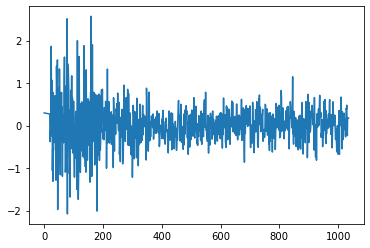

In [32]:
plt.plot(X_test[0])

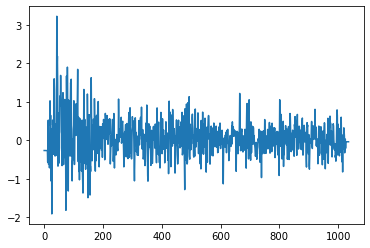

In [33]:
plt.plot(X_test[1])

Idk how much this would help but i recall that certain algorithms do better when the data is normalized. Maybe we can try implementing that and see how it does.
I think sklearn has some standard scaler that normalizes the data in a way to be used for ML purposes
white_check_mark
eyes
raised_hands





11:14
We can also look into the documentations and see what parameters we think has a big impact on the classification
11:15
and tweak those one at a time to see which has the biggest impact

In [34]:
from sklearn import tree
import dtreeviz # will be used for tree visualization

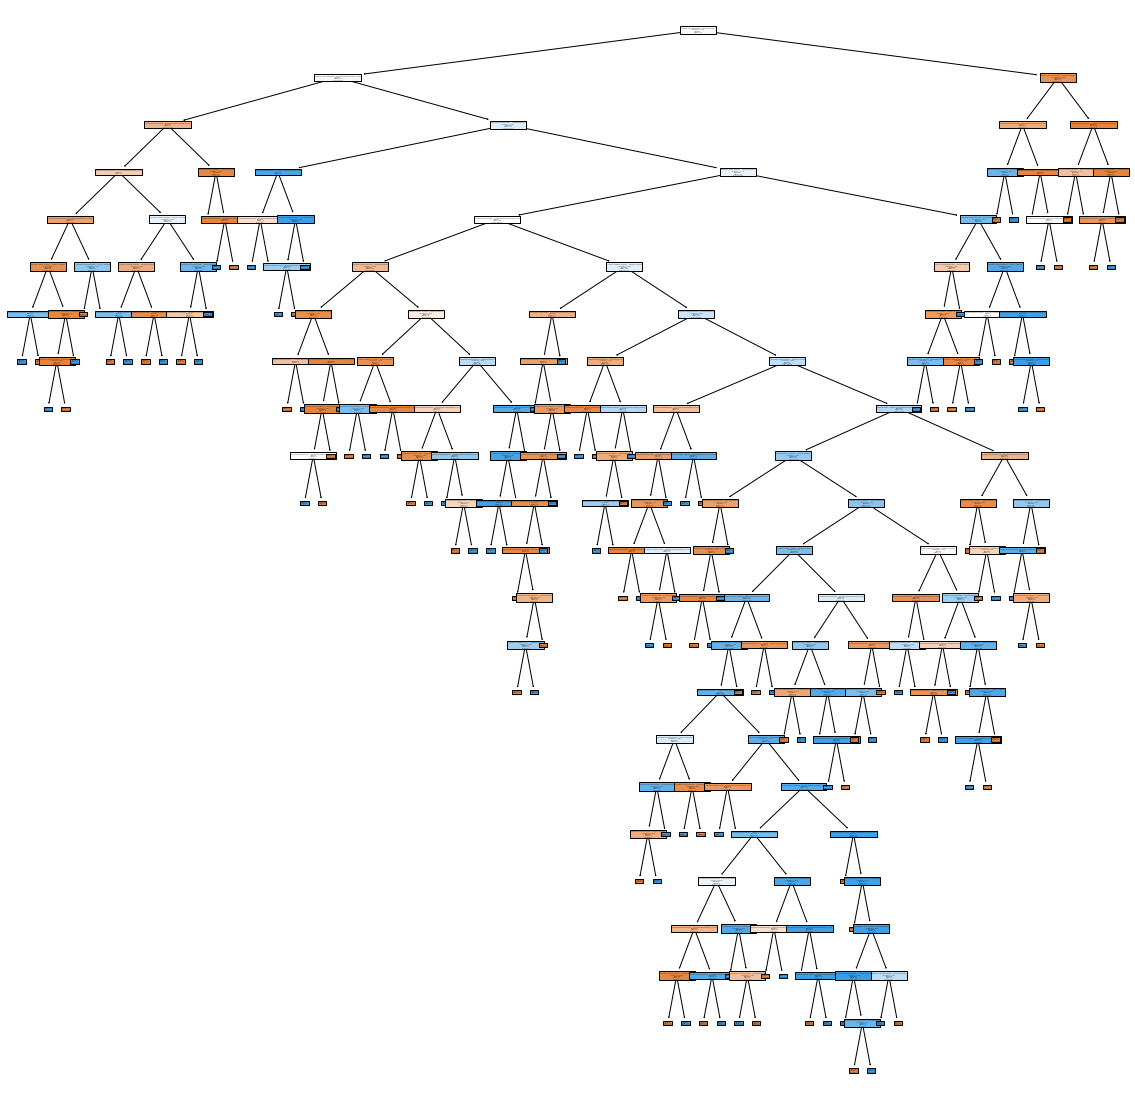

In [35]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(clf.estimators_[0], feature_names=X, filled=True)

In [36]:
rf = RandomForestClassifier(n_estimators=100, max_depth=3)
rf.fit(X, y)

RandomForestClassifier(max_depth=3)

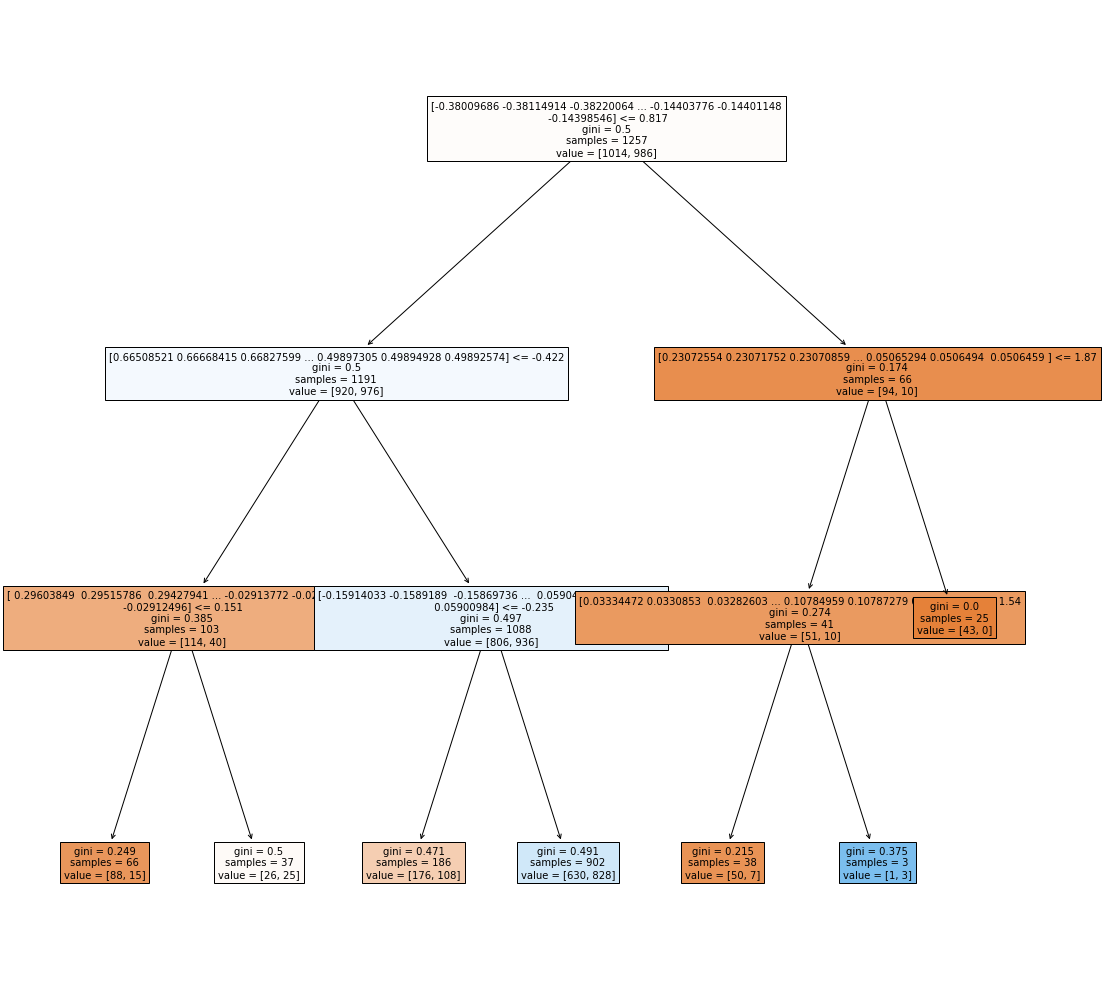

In [37]:
plt.figure(figsize=(18,18))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X, filled=True, fontsize = 10)

In [38]:
viz = dtreeviz.model(rf.estimators_[0], X, y, feature_names=X, target_name="Target")

In [39]:
viz.view() 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

[Text(0.5769230769230769, 0.875, 'X[835] <= 0.817\ngini = 0.5\nsamples = 1257\nvalue = [1014, 986]\nclass = highz'),
 Text(0.3076923076923077, 0.625, 'X[541] <= -0.422\ngini = 0.5\nsamples = 1191\nvalue = [920, 976]\nclass = noise'),
 Text(0.15384615384615385, 0.375, 'X[265] <= 0.151\ngini = 0.385\nsamples = 103\nvalue = [114, 40]\nclass = highz'),
 Text(0.07692307692307693, 0.125, 'gini = 0.249\nsamples = 66\nvalue = [88, 15]\nclass = highz'),
 Text(0.23076923076923078, 0.125, 'gini = 0.5\nsamples = 37\nvalue = [26, 25]\nclass = highz'),
 Text(0.46153846153846156, 0.375, 'X[941] <= -0.235\ngini = 0.497\nsamples = 1088\nvalue = [806, 936]\nclass = noise'),
 Text(0.38461538461538464, 0.125, 'gini = 0.471\nsamples = 186\nvalue = [176, 108]\nclass = highz'),
 Text(0.5384615384615384, 0.125, 'gini = 0.491\nsamples = 902\nvalue = [630, 828]\nclass = noise'),
 Text(0.8461538461538461, 0.625, 'X[1008] <= 1.87\ngini = 0.174\nsamples = 66\nvalue = [94, 10]\nclass = highz'),
 Text(0.769230769230

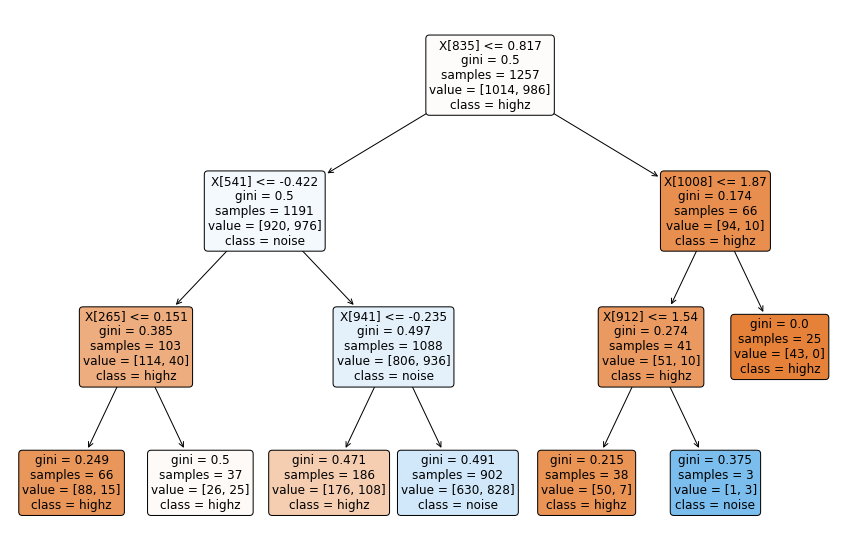

In [40]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0],
          class_names=["highz", "noise"], 
          filled=True, impurity=True, 
          rounded=True)

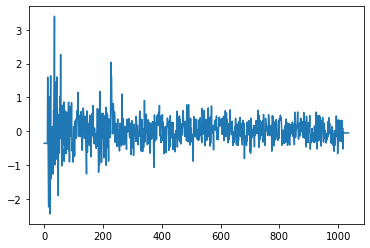

In [45]:
plt.plot(X[42])

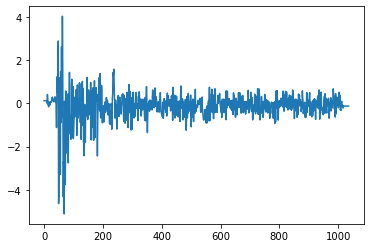

In [42]:
plt.plot(X[984])

## Plotting
https://garg-mohit851.medium.com/random-forest-visualization-3f76cdf6456f 

https://builtin.com/data-science/random-forest-python-deep-dive

https://vitalflux.com/random-forest-classifier-python-code-example/

https://stackabuse.com/random-forest-algorithm-with-python-and-scikit-learn/

#GRIDSEARCHCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html